# MNIST Sample

This notebook creates a sample model for MNIST using Tensorflow and SenseTheFlow.

As a sample, it is an overkill that will use Keras Resnet50 implementation.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from SenseTheFlow.experiment import Experiment, Mode, ExperimentOutput

## Define the Model

Models are now sub-classes from `tf.keras.Model`. This is to make user code and the library itself compatible with future Tensorflow 2.0 usage.

Such models should:
* Define layers in its `__init__(self, mode, params)` constructor. The easiest way to do so would be by using either `tf.keras.layers` or `keras.layers`.
* Call layers in its `call(self, x, y, mode, params)` method.

The `call` method must return a `ExperimentOutput` instance. Its property `loss` must be different from `None`, either a tensor or a constant.

In [2]:
class MNIST(tf.keras.Model):
    def __init__(self, mode, params):
        # Always call `super` constructor
        super(MNIST, self).__init__()
        
        # Define layers
        self.conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', data_format='channels_first')
        self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', data_format='channels_first')
        
        # Example on how to add L2 to a layer, no need to manually touch the loss term, it will be automatically used
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', data_format='channels_first', 
                                           kernel_regularizer=tf.keras.regularizers.l2(0.001)) 
        
        self.pool = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_first')
        self.dense = tf.keras.layers.Dense(10)
        
        # Optimizer and other params
        self.params = params
        self.mode = mode
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        
    def call(self, inputs, training, step):
        if self.mode != Mode.TEST:
            x, y = inputs
        else:
            x = inputs
            
        # Call layers
        outputs = self.conv1(x)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        outputs = self.pool(outputs)
        logits = self.dense(outputs)
        
        # When `mode == Mode.TEST`, `y` will be None
        loss = 0.0
        if self.mode != Mode.TEST:
            # Compute loss
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
            loss = tf.reduce_mean(loss)
            
        # Summary examples
        if tf.equal(tf.math.floormod(step, self.params['summary_steps']), 0):
            with tf.device("cpu:0"):
                tf.summary.scalar('loss', loss, step=step)
        
        # `call` must return `ExperimentOutput`, and it must be constructed as a "key=value" object
        return ExperimentOutput(
            outputs={
                'probabilities': tf.nn.softmax(logits),
                'number': tf.argmax(logits)
            },
            loss=loss
        )

## Define some params

In [3]:
params = {
    'model_name': 'mnist-test',
    'learning_rate': 3e-4,
    'batch_size': 128,
    'summary_steps': 1000
}

## Define the data pipeline

It can be done in multiple ways, the only restriction is for your `dataset_fn` to return a `tf.Dataset` instance. Here, we will use `Keras` to directly obtain images and labels, but one could read from disk or whatever other option.

Here using a generator might not be the best idea (performance-wise), as we have all data already loaded into RAM. However, the general case will be generators, thus it is the pipeline used.

In [4]:
def mnist_generator():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    for image, label in zip(x_train, y_train):
        # Here we simply yield two values, but you could easily construct other returns.
        # More examples are provided below
        yield image[..., np.newaxis], label
        
# `dataset_fn` always receives the run `mode`.
def dataset_fn(mode, params):
    # Create a dataset from a geneator
    dataset = tf.data.Dataset.from_generator(
        generator=mnist_generator, 
        output_types=(tf.float32, tf.int32),
        output_shapes=([28, 28, 1], None)
    )

    # Batch inputs, make sure all batches are equal-sized (drop_remainder=True)
    dataset = dataset.batch(params['batch_size'], drop_remainder=True)
    # Prefetch some batches
    dataset = dataset.prefetch(8)
    # Repeat for 100 epochs, leave blank to repeat indefinately
    dataset = dataset.repeat(100)
    # Return the dataset
    return dataset

In [5]:
# The new way to tell TF not to use all GPUs but only the exact amount needed
# The next cell will attempt to use GPU space if executed, so do it now
#  otherwise it would be fine to do it just before running the model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


tf.Tensor(5, shape=(), dtype=int32)


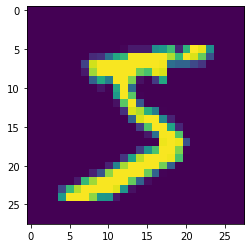

In [6]:
# Errors in the above functions are particularly hard to debug once in the network
# you can manually inspect everything works like this

with tf.device('/cpu:0'):
    dataset = dataset_fn(Mode.TRAIN, params)
    for x, y in dataset:
        for batch in range(params['batch_size']):
            print(y[batch])
            plt.imshow(x[batch, ..., 0])
            break
        break

In [7]:
!nvidia-smi

Fri Jun 12 18:28:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 418.43       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   49C    P2    63W / 250W |    394MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   44C    P2    55W / 250W |   8100MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

## Define the experiment

Experiments are executed in two steps:

1. Experiment discovery: That is, given the experiment name (or model name) find the corresponding saved checkpoint (if any). This process might not be completed immediately due to:
  * Remote execution, when the model has to be fetched from the main data-storage
  * Local jupyter execution, when the model is selected from the drop-down
  
2. Experiment execution: Calling train/eval/test and waiting for the results. SenseTheFlow is asynchronous by default, which means that all executions are done in a background thread. Some mechanisms are provided to block until certain events
  * `wait_ready` might be used to wait until the experiment actually starts running (waits until tensorflow has setup the GPU memory and starts iterating)
  * `wait_for` can be used to wait for a certain number of steps or seconds
  * `wait` can be used to block until the experiment completely finishes
  
Alternatively, asynchronous execution can be turned off by specifying `sync=True` to any of the calls above.

In [5]:
def once_discovered(experiment):
    # Call train, by default will:
    #  * checkpoint_steps=1000, saves the model every 1000 steps
    #  * summary_steps=100, saves summaries every 100 steps
    #  * config=None, which means it will *not* use all gpus, but gradually expand memory
    # By default the model is executed in a background thread, which might be a BAD idea
    #  if you have errors and want to find them
    #  use sync=True to block and run normally
    print('TRAIN')
    context = experiment.train(dataset_fn)
    
    # Wait until it actually is running
    context.wait_ready()

In [ ]:
# As always, you may not want debug messages

import logging
logger = tf.get_logger()
logger.setLevel(logging.DEBUG)

In [8]:
# By default everything is run in Graph mode (ie. compiled, fast). It can be optionally executed eagerly (step by step) by using
#tf.config.experimental_run_functions_eagerly(True)

# Supply the name, model CLASS, params and where to write
experiment = Experiment(params['model_name'], MNIST, params=params, persistent_path=os.path.join('/tmp/', params['model_name']))
# Tell it which GPU to use
experiment.assign_gpu(1)
# And search for existing models
experiment.run_local(once_discovered, prepend_timestamp=True)

Output()

## Waiting

An experiment can be waited, in general, by calling any of `wait_ready` or `wait`. As opposed to waiting on a context, waiting on an experiment will wait for all individual runs to end (for example, wait for both train and eval to end)

It is encoraged to call `wait_ready` before continuing, to ensure the context is registered.

In [16]:
experiment.wait_ready()
# experiment.wait()

## Further using the context

The training `context` above, inside `once_discovered`, can be recovered with:

In [17]:
# As it is the first and only call to train, out context is in position [0] of Mode.TRAIN
# Further calls would be in next positions, ordered by call order always

context = experiment.get_context(Mode.TRAIN)[0]

In [18]:
# Now we can do either of this:

# context.save()
# context.reattach() # Redraws the TQDM bars
# context.stop() # Stops training

# Wait until it finishes, can exit waiting by pressing stop or CTRL+C, training won't be affected.
# context.wait()

context.stop()